In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pastas as ps
import datetime as dt
from scipy.stats import norm, probplot

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

%config InlineBackend.figure_format = 'retina'

# Beoordeling Tijdreeksmodellen

Een veelgestelde vraag is hoe je een geoptimaliseerd tijdreeksmodel moet beoordelen. In dit notebook worden methodes voor modelbeoordeling gepresenteerd en geïllustreerd met voorbeelden uit de praktijk. 

**Inhoudsopgave**

- [Introductie](#Introductie)
- [Visuele beoordeling](#Visuele-beoordeling)
- [Fit statistieken](#Fit-statistieken)
- [Testen model](#Testen-model)
- [Modelonzekerheid](#Modelonzekerheid)
- [Hydrologische beoordeling](#Hydrologische-beoordeling)
- [Discussie](#Discussie)
- [Referenties](#Referenties)

## Introductie

Voor het gebruiken of afkeuren van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria worden gesteld voor het beoordelen van het model. Dit notebook geeft een overzicht van veel voorkomende methodes om tijdreeksmodellen te beoordelen. Per onderwerp wordt de belangrijkste achtergrondinformatie gepresenteerd. Dit document bevat geen volledig overzicht van al het onderzoek en werk wat op dat vlak is gedaan. Voor de lezers die daarin geïnteresseerd zijn hebben we referenties opgenomen waarmee men dieper in het onderwerp kan duiken.

### Algemeen stappenplan

We presenteren hier een aantal stappen die vaak worden toegepast om tijdreeksmodellen te beoordelen. Er is niet zoiets als een definitief stappenplan voor modelbeoordeling, dus er bestaan ook andere methodes voor modelbeoordeling die niet in dit notebook zijn opgenomen. Ook de volgorde van de stappen staat niet vast, maar is logisch gestructureerd naar inzicht van de auteurs. 

- **Visuele beoordeling:** Een eerste goede stap is vaak een visuele beoordeling van het tijdreeksmodel. Het gedrag van het model wordt visueel geïnspecteerd waarbij veel waardevolle inzichten worden verkregen over het model. Het nadeel van deze stap is dat deze relatief veel tijd kost als het om veel modellen gaat. 
- **Fit-statistieken:** De tweede stap is een beschouwing van de overeenkomst tussen model en metingen (de fit) op basis van fit-statistieken. Het voordeel van deze stap is dat er een objectieve maat wordt gegeven die iets zegt over overeenkomst tussen model en metingen. Het nadeel van deze stap is dat er veel waardevolle informatie verloren gaat bij het terugbrengen van de prestatie van het model tot enkele getallen.
- **Testen model:** De derde stap is het testen van het model (dit wordt ook vaak validatie genoemd), door bijvoorbeeld een simulatie te doen met het model op een periode met metingen die niet zijn gebruikt in de kalibratie. Hiermee wordt het model getest op informatie die niet is gebruikt bij het optimaliseren van de modelparameters.
- **Modelonzekerheid:** De vierde stap is het beschouwen van de modelonzekerheid. Daarbij stellen we eigenlijk de vraag: kunnen de modelparameters goed bepaald worden? Voordat we die onzekerheid kunnen beoordelen, moet het model aan enkele statistische eisen voldoen. Als het model niet aan die eisen voldoet, kunnen we de onzekerheid van de modelparameters niet goed inschatten, en dus niet gebruiken bij onze beoordeling. De parameters worden goed geschat, maar de onzekerheden dus niet. 
- **Hydrologische beoordeling:** De laatste stap die we hier presenteren is de hydrologische beoordeling waarbij de resultaten van de tijdreeksmodellen naast de hydrologische kennis over het systeem worden gelegd. Dit kan zowel op invididuele tijdreeksmodellen worden toegepast als ruimtelijk op de resultaten van meerdere tijdreeksmodellen. Hier wordt bijvoorbeeld de kennis over het hydrologische systeem gebruikt om de modellen te beoordelen, maar worden ook de resultaten van de modellen gebruikt om het hydrologisch inzicht in het systeem uit te breiden.

In [2]:
# hulpfuncties om herhaling van code te minimaliseren

def plot_results_ml(ml):
    """Plot model simulation and residuals.
    
    Model simulation and observations in top axes, residuals on
    second set of axes.
    
    Paramters
    ---------
    ml : pastas.Model
        plot results for model
        
    Returns
    -------
    fig : Figure
        return figure handle

    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ml.plot(ax=ax1, legend=False)
    ax1.set_ylabel('stijghoogte [m NAP]')
    ax1.grid()
    handles, labels = ax1.get_legend_handles_labels()
    labels = ['Head', 'Simulation']
    ax1.legend(handles, labels, loc="upper left", ncol=2)
    ml.residuals().plot(ax=ax2, color="C1", label="residuals")
    ax2.axhline(0.0, linestyle="dashed", color="k", lw=1.5)
    ax2.set_ylabel('residuen [m]')
    ax2.grid()
    fig.tight_layout()

    return fig


def fit_stats_model(ml):
    """Fit statistics for a model
    
    Parameters
    ----------
    ml : pastas.Model
        calculate stats for model
        
    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing statistics

    """
    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of the squares of the error (sse)",
        "Explained variance percentage (evp)",
        "R-squared (rsq)"
    ]

    df = pd.DataFrame(index=stats, columns=["waarde", "eenheid"])
    # fit statistics kunnen in pastas worden opgevraagd met:
    # `<model>.stats.<naam statische parameter>()`
    df.loc[stats[0], :] = ml.stats.mae(), "m"
    df.loc[stats[1], :] = ml.stats.rmse(), "m"
    df.loc[stats[2], :] = ml.stats.sse(), "m$^2$"
    df.loc[stats[3], :] = ml.stats.evp(), "%"
    df.loc[stats[4], :] = ml.stats.rsq(), "-"

    return df


def get_stats_train_test(ml, train_tmin, train_tmax,
                         test_tmin, test_tmax):
    """Get statistics for training and testing periods
    
    Paramters
    ---------
    ml : pastas.Model
        calculate train/test stats for model
    train_tmin : str, pd.Timestamp
        start time for training period
    train_tmax : str, pd.Timestamp
        end time for training period
    test_tmin : str, pd.Timestamp
        start time for testing period
    test_tmax : str, pd.Timestamp
        start time for testing period
        
    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing statistics for training/testing
        periods
        
    """
    sim = ml.simulate(tmin=train_tmin, tmax=train_tmax)
    obs = ml.oseries.series_original[train_tmin:str(int(train_tmax)-1)]

    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of squares of the error (sse)",
        "Explained variance percentage (evp)",
        "R-squared (rsq)"
    ]

    df = pd.DataFrame(index=stats, columns=[
                      f"training: {train_tmin}-{train_tmax}",
                      f"test: {test_tmin}-{test_tmax}", "eenheid"])

    # statistieken periode 1985 - 2000
    df.loc[stats[0], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3],
           f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.rsq(obs=obs, sim=sim)

    # statistieken periode 2000 - 2015
    sim = ml.simulate(tmin=test_tmin, tmax=test_tmax)
    obs = ml.oseries.series_original[test_tmin:str(int(test_tmax)-1)]
    df.loc[stats[0], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.rsq(obs=obs, sim=sim)

    df.loc[:, "eenheid"] = ["m", "m", "m$^2$", "%", "-"]

    return df

In [3]:
# set options to display DataFrames in PDF
pd.set_option("display.latex.repr", True)
pd.set_option("display.latex.longtable", True)


def _repr_latex_(self):
    latex = """\\begin{center}
    {%s}
    \\end{center}""" % self.to_latex(float_format="{:0.3f}".format, bold_rows=True)
    return latex


pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

In [4]:
# %%html
# <style>
# table {float: left}
# </style>

## Visuele beoordeling

Een eenvoudige manier om een tijdreeksmodel te beoordelen is het visualiseren van de resultaten. De modelsimulatie wordt samen met de metingen in een grafiek weergegeven. Vaak worden de modelresiduën ook gepresenteerd. Aan de hand van beide grafieken kan visueel beoordeeld worden of de simulatie door de metingen loopt, of de metingen helemaal niet goed benaderd. Ook kan beoordeeld worden in welke periodes het model het goed doet, en in welke periodes niet. Is het model bijvoorbeeld goed in staat om de pieken en dalen te simuleren?

<hr>

#### Voorbeeld visuele beoordeling 1

Als voorbeeld van een visuele beoordeling is een tijdreeksmodel geselecteerd waarin de grondwaterstand wordt verklaard aan de hand van neerslag en verdamping. De modelsimulatie (blauwe lijn) en de metingen (zwarte punten) staan in de bovenste grafiek. De residuen (oranje lijn) zijn in de onderste grafiek weergegeven. 

In de figuur is te zien dat de simulatie en de metingen goed overeenkomen. In de residuen is te zien dat het verschil tussen model en meting het grootste is bij de extremen: de dalen in de zomer en de pieken in de winter. De residuen laten echter geen duidelijk patroon zien en zijn netjes verdeeld om de nul-lijn, dus er is geen sprake van een structurele fout in het model. 

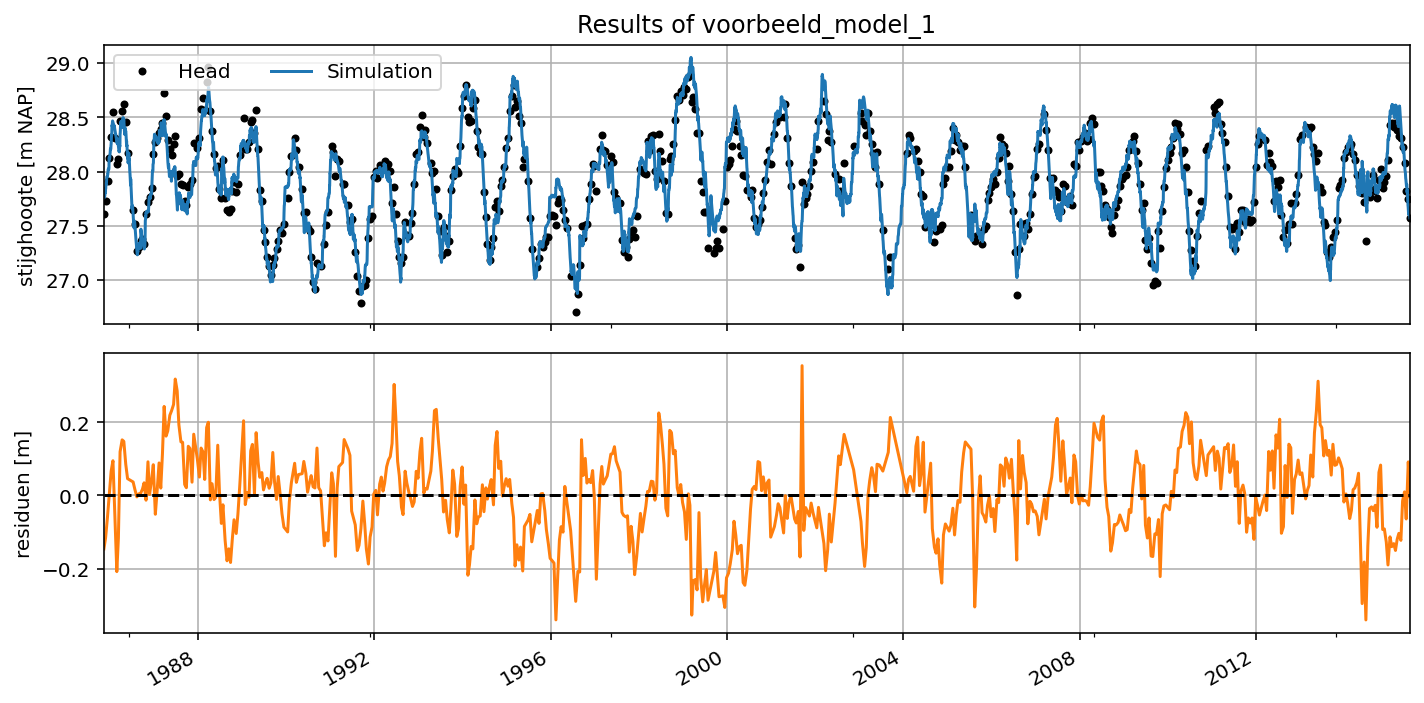

In [5]:
# inladen voorbeeld model
ml1 = ps.io.load("./data/basic_model.pas")

# plot resultaten
f1 = plot_results_ml(ml1)

<hr>

#### Voorbeeld visuele beoordeling 2

Onderstaand voorbeeld laat een tijdreeksmodel zien waar de modelsimulatie (blauwe lijn) slecht overeenkomt met de metingen (zwarte punten). De simulatie wijkt tot wel 2 meter af van de gemeten grondwaterstand. Met dit model is het niet mogelijk om betrouwbare simulaties te maken.

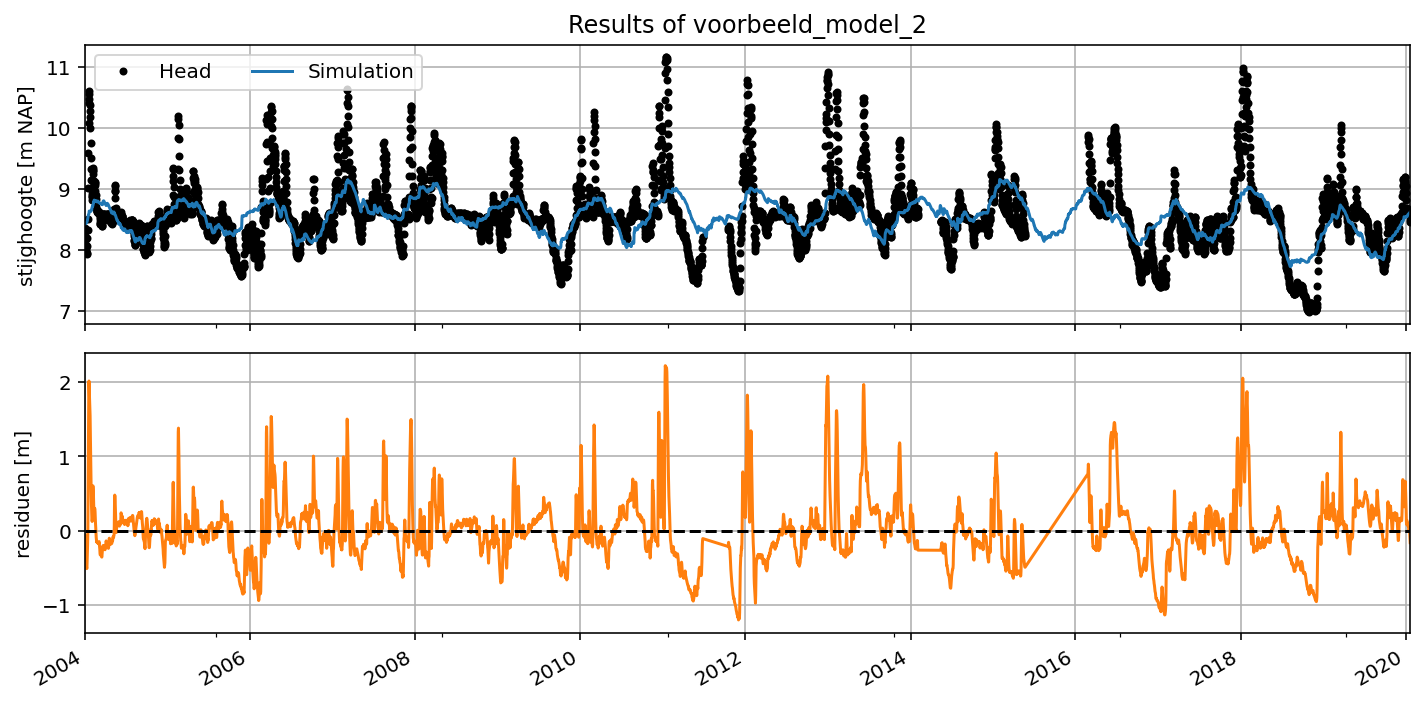

In [6]:
# model uit voorbeeld notebook
ml_visueel2 = ps.io.load("./data/vb_visueel2.pas")
ml_visueel2.solve(tmin="2004", report=False)

# plot resultaten
f2 = plot_results_ml(ml_visueel2)

<hr>

## Fit statistieken

Naast de visuele beoordeling kunnen de modelresultaten ook worden beoordeeld met behulp van statistische parameters. Er zijn verschillende statistische parameters om de fit tussen gemodelleerde en gemeten grondwaterstanden in getallen uit te drukken. De statistieken kunnen opgedeeld worden in statistieken die de modelfout (de residuen) uitdrukken als een getal, en statistieken die proberen de "goodness-of-fit" uit te drukken als een getal. In onderstaande tabel zijn een aantal veelgebruikte statistieken opgenomen. Voor een overzicht van verschillende fit-statistieken die vaak worden toegepast in de hydrologie zie [Jackson et al. (2019)](#Referenties).

Het wordt aanbevolen meerdere fit-statistieken tegelijk te gebruiken voor de beoordeling van tijdreeksmodellen. Elke statistiek heeft namelijk zijn eigen specifieke toepassing en geen enkel getal kan alle complexiteit met betrekking tot de fit van een model in een enkel getal uitdrukken.

<!-- | afkorting         | naam                               | formule                                                                                          | optimale waarde | min          | max      | type            |
|:------------------|:-----------------------------------|:------------------------------------------------------------------------------------------------:|:---------------:|:------------:|:--------:|----------------:|
| $\text{SSE}$      | som kwadratische fout              | $$\sum\limits_{i=1}^{N}(y_i - \hat{y_i})^2$$                                                     | 0               | 0         | $\infty$ | residuën        |
| $\text{MAE}$      | gemiddelde absolute fout           | $$\sum\limits_{i=1}^{N}\frac{ \left| y_i - \hat{y_i} \right| }{N}$$                              | 0               | 0         | $\infty$ | residuën        |
| $\text{RMSE}$     | wortel kwadratisch gemiddelde fout | $$\sqrt{ \sum\limits_{i=1}^{N} \frac{ (y_i - \hat{y_i})^2}{N}}$$                                 | 0               | 0         | $\infty$ | residuën        |
| $\text{EVP}^{**}$ | verklaarde variantie               | $$\frac{ \sigma_y^2 - \sigma_r^2}{\sigma_y^2} \cdot 100$$                                        | 100%            |-$\infty^*$ | 100      | goodness-of-fit |
| $R^2$             | determinatiecoëfficient$^{***}$     | $$1 - \frac{ \sum\limits_{i=1}^{N}(y_i - \hat{y_i})^2}{\sum\limits_{i=1}^{N}(y_i - \bar{y})^2}$$ | 1               | -$\infty$ | 1        | goodness-of-fit | -->

<img src="data/fit_stats_table.png" width="800">

$^{*}$ In verschillende tijdreeksanalyseprogramma's, waaronder Menyanthes en Pastas, wordt de minimale waarde van de EVP begrenst op 0.

$^{**}$ [Von Asmuth (2012)](#Referenties)

$^{***}$ De determinatiecoëfficient wordt in hydrologische modellen ook vaak de Nash Sutcliffe model efficiency (NSE) coefficient genoemd.

In de formules hierboven is $N$ het aantal metingen, $y_i$ en $\hat{y_i}$ zijn de gemeten en met het model gefitte grondwaterstand op tijdstip $i$, respectievelijk. $\bar{y}$ is het gemiddelde van de metingen. $\sigma_y^2$ en $\sigma_r^2$ zijn de variantie in de gemeten grondwaterstanden en de variantie van de residuën $r$, waarbij $\sigma_y^2 = \tfrac{1}{N} \sum\limits_{i=1}^{N}\left(y_i - \bar{y} \right)^2$ en $\sigma_r^2 = \tfrac{1}{N} \sum\limits_{i=1}^{N}\left(r_i - \bar{r} \right)^2$.

#### Verschil MAE en RMSE

De "Mean Absolute Error" (MAE) (in het Nederlands: gemiddelde absolute fout) is de het gemiddelde van de absolute waardes van alle fouten. Hiermee wordt elke fout even zwaar gewogen. De "Root Mean Squared Error" (RMSE) (in het Nederlands: wortel kwadratisch gemiddelde fout) worden de fouten gekwadrateerd waardoor grote fouten een relatief zwaardere weging krijgen.

#### Verschil $R^2$ en $\text{EVP}$

De verklaarde variantie ($\text{EVP}$) en de determinatiecoëfficient ($R^2$) zijn subtiel verschillend. De waarde van de $\text{EVP}$ is gelijk aan $R^2$ als het gemiddelde van de residuen gelijk is aan nul. De optimalisatie van een tijdreeksmodel probeert het model zo de fitten dat het gemiddelde van de residuen gelijk is aan nul, dus vaak hebben deze statistieken dezelfde waarde.

<hr>

#### Voorbeeld fit statistiek 1

De fit statistieken van het eerste, hierboven weergegeven model staan in de tabel hieronder. De gemiddelde absolute modelfout bedraagt ca. 9 cm. De fit-statistieken geven aan dat het model goed overeenkomt met de metingen; de verklaarde variantie (of EVP) is 92.9%. 

In [7]:
# bereken statistieken tabel
df = fit_stats_model(ml1)

# geef tabel weer
df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_1")

,waarde,eenheid
Mean absolute error (mae),0.090,m
Root mean squared error (rmse),0.114,m
Sum of the squares of the error (sse),8.431,m$^2$
Explained variance percentage (evp),92.914,%
R-squared (rsq),0.929,-


<hr>

#### Voorbeeld fit statistiek 2

De fit statistieken van het tweede voorbeeldmodel zijn een stuk slechter. Zoals ook al visueel aangegeven komt het model niet goed overeen met de metingen. De verklaarde variantie (EVP) waarde is slechts 39,6% en de gemiddelde, absolute afwijking (MAE: mean absolute error) is maar liefst 31 cm. 

In [8]:
# bereken statistieken tabel
df = fit_stats_model(ml_visueel2)

# geef tabel weer
df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_2")
#df

,waarde,eenheid
Mean absolute error (mae),0.314,m
Root mean squared error (rmse),0.452,m
Sum of the squares of the error (sse),1097.701,m$^2$
Explained variance percentage (evp),36.210,%
R-squared (rsq),0.362,-


<hr>

### Overfitten

Als er meer verklarende variabelen (en daarmee modelparameters) aan een tijdreeksmodel worden toegevoegd, wordt de fit in principe beter, zelfs als de verklarende variabele weining of geen invloed heeft op de stijghoogte. Het model kan deze extra vrijheidsgraden (parameters) namelijk gebruiken om het model beter op de metingen te fitten. Het toevoegen van een niet-relevante verklarende variabele zorgt niet voor een verbetering in de voorspellende waarde van het model. Het fenomeen waarbij meer parameters aan een model worden toegevoegd dan gerechtvaardigd is op basis van de data heet overfitting. Overfitting kan vaak herkend worden aan de standaardfouten van de parameters (zie [Modelonzekerheid](#Modelonzekerheid)) ([Van Geer, 2012](#Referenties)).

Er zijn statistieken die een relatieve score berekenen op basis van de fit van het model waarbij gestraft wordt voor het aantal parameters. Hiermee kan worden ingeschat of het toevoegen van parameters tot een significante verbetering heeft geleid van het model. De Akaike Information Criterion (AIC) en de Bayesian Information Criterion (BIC) zijn twee voorbeelden daarvan. Zowel de AIC als de BIC zijn een maat voor de relatieve hoeveelheid informatie die verloren is gegaan in het model (zogenaamde "penalized likelihood criteria"). Het zijn dus relatieve waardes en worden gebruikt om verschillende modellen voor dezelfde meetreeks met elkaar te vergelijken. Als de AIC en BIC lager worden na het toevoegen van een verklarende variabele betekent dit dat het model verbetert (er gaat relatief minder informatie verloren). Als de AIC en BIC hoger worden dan heeft het toevoegen van de parameters niet voldoende bijgedragen aan een verbetering van het model. Voor dit notebook is het alleen van belang te weten dat het verschil tussen de AIC an BIC zit in de manier waarop er gestraft wordt voor het aantal modelparameters. De BIC straft over het algemeen iets zwaarder voor het toevoegen van parameters.

Samenvattend kunnen deze statistieken gebruikt worden om verschillende tijdreeksmodellen voor hetzelfde meetpunt (met andere modelstructuren) onderling te vergelijken. Deze statistieken geven een relatieve score voor de fit (hoe goed het model op de metingen past) waarbij er gestraft wordt voor het aantal modelparameters. Hoe lager de statistiek, hoe minder informatie in het model verloren is gegaan, en dus is het model mogelijk beter.

<hr>

#### Voorbeeld AIC/BIC

Voor dit voorbeeld maken we een tijdreeksmodel voor een meetpunt (40CP0393 (filter 4)) waarbij neerslag en verdamping lineair gecombineerd worden als schatting van de grondwateraanvulling. We optimaliseren het model en berekenen de EVP, AIC en BIC. Vervolgens voegen we de invloed van de rivierwaterstand toe aan het tijdreeksmodel. Eerst kiezen we daarvoor de exponentiële responsfunctie (2 parameters), vervolgens doen we dat nog eens maar dan met de Gamma responsfunctie (3 parameters). Voor beide modellen berekenen we weer de EVP, AIC en BIC. Uit de resulterende tabel is op te maken dat het toevoegen van de rivier een enorme verbetering oplevert. De EVP wordt aanzienlijk hoger, en de AIC en BIC aanzienlijk lager. Nu willen we weten welke van de twee modellen met rivier beter is.

Op basis van de EVP zouden we concluderen dat het model met rivier en de Gamma-responsfunctie het beste is. De AIC is ook het laagste voor dit model, dus blijkbaar neemt volgens deze statistiek de kwaliteit van de fit voldoende toe om de toevoeging van een extra parameter te rechtvaardigen. Op basis van de AIC zouden we wederom dit model als beste selecteren. De BIC (die iets zwaarder straft voor extra parameters) is het laagste voor het model met rivier en de exponentiële respons, dus volgens deze statistiek is dat het beste model. Helaas geven de statistieken in dit geval geen eenduidig antwoord, dus is het aan de gebruiker om een keuze te maken. Gezien het geringe verschil in zowel de AIC en BIC tussen de tijdreeksmodellen met rivier zijn beide modellen voldoende goed om verdere analyses mee te doen.

In [9]:
df = pd.DataFrame(
    index=["model zonder rivier", "model met rivier (Exponential)", "model met rivier (Gamma)"], 
    columns=["EVP", "AIC", "BIC"], data=np.nan
)

# Lees CSV bestanden in voor model
head = pd.read_csv("../modelstructuur/data/40CP0393-004.csv", index_col=0, parse_dates=True, 
                   squeeze=True).resample("D").mean().dropna()
prec = pd.read_csv("../modelstructuur/data/RD_Nijmegen.csv", index_col=0, parse_dates=True) * 1e3
evap = pd.read_csv("../modelstructuur/data/EV24_Deelen.csv", index_col=0, parse_dates=True) * 1e3

# Maak model o.b.v. grondwateraanvulling
ml = ps.Model(head, name="40CP0393 (filter 4)")
sm = ps.RechargeModel(prec, evap, name="rch", recharge=ps.rch.Linear(), rfunc=ps.Gamma)
ml.add_stressmodel(sm)
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=True)
df.loc["model zonder rivier"] = ml.stats.evp(), ml.stats.aic(), ml.stats.bic()

# Voeg rivier toe met Exponential respons
rivier = pd.read_csv("../modelstructuur/data/40CP0393-rivier.csv", index_col=0, parse_dates=True, squeeze=True)
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Exponential)
ml.add_stressmodel(sm2)
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=True)
df.loc["model met rivier (Exponential)"] = ml.stats.evp(), ml.stats.aic(), ml.stats.bic()

# Voeg rivier toe met Gamma respons
ml.del_stressmodel("rivier")
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Gamma)
ml.add_stressmodel(sm2)
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=True)
df.loc["model met rivier (Gamma)"] = ml.stats.evp(), ml.stats.aic(), ml.stats.bic()

# Geef tabel weer
df.style.set_precision(3)

,EVP,AIC,BIC
model zonder rivier,50.475,926.498,964.277
model met rivier (Exponential),93.783,445.418,495.790
model met rivier (Gamma),94.162,444.027,500.696


## Testen model

Het doel van deze stap is om te controleren of het model geschikt is voor het beoogde doel. Deze stap wordt ook vaak model-validatie genoemd (voor een betoog over de juiste terminologie, zie bijvoorbeeld [Konikow et al. (1992)](#Referenties)). Cross-validatie (in het Engels: 'split-sample testing') is een veel toegepaste methode in de neerslag-afvoer hydrologie om modellen te testen. Het is een methode om de voorspellende waarde van een model te beoordelen. Bij deze methode splitsen we een tijdreeks in twee delen, een trainings-deel en een test-deel. Het deel van de metingen dat we gebruiken om het model te kalibreren heet de trainings-set. Vervolgens gebruiken we het het gekalibreerde model om een simulatie te berekenen voor de tweede periode. Dit deel noemen we de test-set. De test set vergelijken we met de metingen om te beoordelen of het model ook goede resultaten oplevert voor het deel waar het niet op gekalibreerd is. Een tijdreeks moet voldoende lang zijn en voldoende metingen bevatten om deze op te kunnen splitsen in een trainings-deel en een test-deel.

De hierboven besproken [fit statistieken](#Fit-statistieken) kunnen ook gebruikt worden om de voorspelling in een testperiode te toetsen. Voor een uitgebreide analyse van een set aan tijdreeksmodellen met deze methode, inclusief een beschouwing van bijbehorende fit-statistieken, zie [Knotters (2012)](#Referenties).

<hr>

#### Voorbeeld model test 1

Het voorbeeld model van hierboven is getest door de dataset op te splitsen in twee periodes. Het model is getraind op de periode 1985 - 2000 en getest op de periode 2000 - 2015. De resultaten staan in de plots hieronder evenals de berekende fit statistieken voor beide periodes.

Het model presteert vrij goed in de test periode wat vertrouwen geeft in de voorspellende waarde van het model. De EVP is in de testperiode weliswaar 3 procentpunt lager dan in de trainingsperiode maar met 90,5% nog steeds relatief hoog. Aan de fit statistieken is duidelijk te zien dat het model vergelijkbaar presteert in de testperiode vergeleken met de trainingsperiode.

In [10]:
# train het model op periode 1985 - 2000, test het model op de periode 2000 - 2015
train_tmin, train_tmax = "1985", "2000"
test_tmin, test_tmax = "2000", "2015"

# kopieer model en train op trainingsperiode
ml_train1 = ml1.copy()
ml_train1.solve(tmin=train_tmin, tmax=train_tmax, report=False)

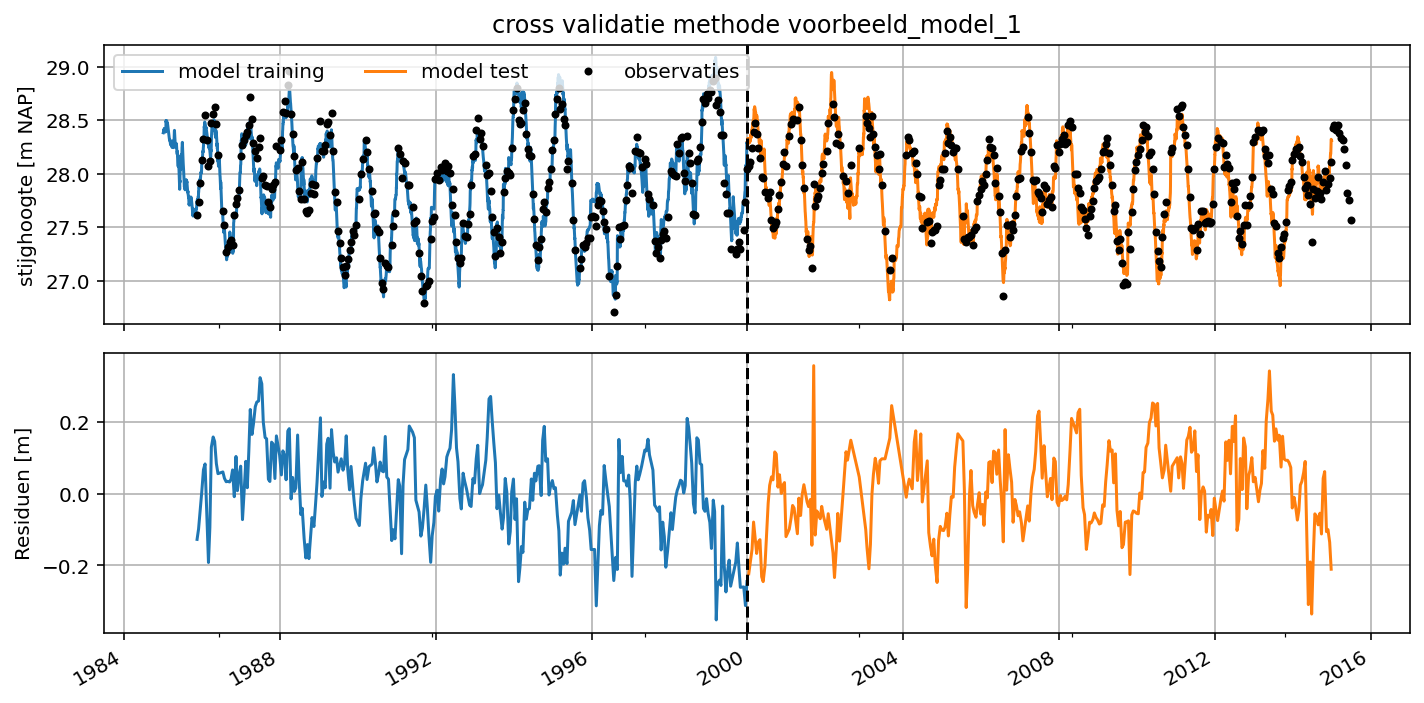

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(ml_train1.simulate(tmin=train_tmin, tmax=train_tmax), label='model training')
ax1.plot(ml_train1.simulate(tmin=test_tmin, tmax=test_tmax), label='model test')
ax1.plot(ml_train1.oseries.series_original, ls='', marker='.',
         label='observaties', color='k')
ax1.legend(loc="upper left", ncol=3)
ax1.grid()
ax1.set_title('cross validatie methode voorbeeld_model_1')
ax1.set_ylabel('stijghoogte [m NAP]')
ax1.axvline(pd.Timestamp(train_tmax), linestyle="dashed", 
            lw=1.5, color="k")

ml_train1.residuals(tmin=train_tmin, tmax=train_tmax).plot(
    ax=ax2, label="residuals train")
ml_train1.residuals(tmin=test_tmin, tmax=test_tmax).plot(
    ax=ax2, label="residuals test")
ax2.axvline(pd.Timestamp(test_tmin), linestyle="dashed", 
            lw=1.5, color="k")
ax2.set_ylabel('Residuen [m]')
ax2.grid()
fig.tight_layout()

In [12]:
# bereken train/test statistieken met hulpfunctie
# train_tmin, train_tmax zijn begin- en eindperiode voor kalibratie
# test_tmin, test_tmax zijn begin- en eindperiode voor validatie
df = get_stats_train_test(ml_train1, train_tmin, train_tmax, 
                          test_tmin, test_tmax)
df.style.set_precision(3)

,training: 1985-2000,test: 2000-2015,eenheid
Mean absolute error (mae),0.097,0.094,m
Root mean squared error (rmse),0.123,0.117,m
Sum of squares of the error (sse),4.727,4.353,m$^2$
Explained variance percentage (evp),93.423,90.409,%
R-squared (rsq),0.934,0.904,-


<hr>

Als het model goed presteert in de test-periode dan is het model dat is afgeleid op basis van de trainings-periode goed genoeg om de grondwaterstanden te voorspellen. Dat geeft vertrouwen dat het model goed presteert, maar dat betekent niet per definitie dat het model ook in de toekomst goede voorspellingen zal geven. Als er in de toekomst iets structureel verandert in het systeem (b.v. een onttrekking die start met pompen buiten beide geselecteerde periodes), dan zal het model dat uiteraard niet goed voorspellen.

Als het model een goede fit heeft in de trainings-periode maar niet in de test-periode, dan is het model geen goede voorspeller van de grondwaterstand. Dit kan verschillende oorzaken hebbben. Oorzaken zijn bijvoorbeeld veranderingen in het systeem die tijdens de test-periode hebben plaatsgevonden zoals de start van een nieuwe onttrekking of het dempen van een watergang, of het meenemen van een invloed in het model die tijdens de trainingsperiode nog niet actief was, of overfitten.

<hr>

#### Voorbeeld model test 2

Hieronder een voorbeeld van een model met een goede fit in de trainingsperiode en een slechte (minder goede) fit in de testperiode. De slechte fit wordt veroorzaakt door een tot nu toe onverklaarde trend in de grondwaterstanden. Deze trend wordt mogelijk veroorzaakt door een externe invloed die niet is meegenomen bij het trainen van het model. Het is daarom niet mogelijk om met het model een goede fit te krijgen voor de testperiode.

In [13]:
# Loads heads and create Pastas model
head2 = ps.read_dino("../modelstructuur/data/B32C0609001_1.csv")
evap = ps.read_knmi("../modelstructuur/data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("../modelstructuur/data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"

ml_cross_validatie = ps.Model(head2, name="B32C0609 (filter 1)")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential, name="rch")
ml_cross_validatie.add_stressmodel(rm)

# train en test periode definieren
train_tmin, train_tmax = "1990", "2005"
test_tmin, test_tmax = "2005", "2019"

# Solve the model
ml_cross_validatie.solve(noise=False, tmin=train_tmin, tmax=train_tmax, 
                         initial=False, report=False, fit_constant=True)

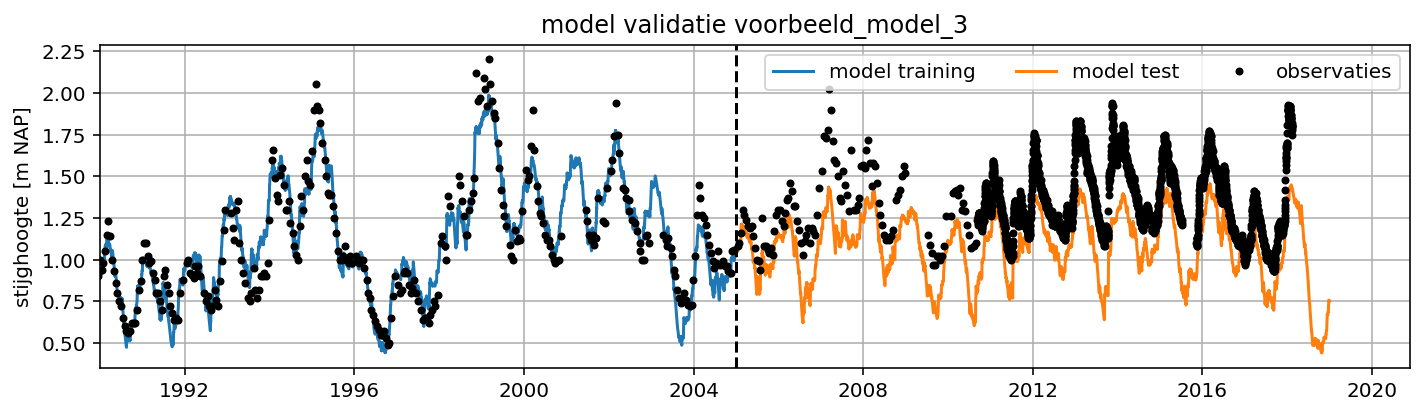

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ml_cross_validatie.simulate(
    tmin=train_tmin, tmax=train_tmax), label='model training')
ax.plot(ml_cross_validatie.simulate(
    tmin=test_tmin, tmax=test_tmax), label='model test')
ax.plot(ml_cross_validatie.oseries.series_original, ls='',
        marker='.', label='observaties', color='k')
ax.set_xlim(left=pd.Timestamp(train_tmin))
ax.axvline(pd.Timestamp(train_tmax), linestyle="dashed", 
            lw=1.5, color="k")
ax.legend(ncol=3)
ax.grid()
ax.set_title('model validatie voorbeeld_model_3')
ax.set_ylabel('stijghoogte [m NAP]')


fig.tight_layout()

In [15]:
# train_tmin, train_tmax zijn begin- en eindperiode voor kalibratie
# test_tmin, test_tmax zijn begin- en eindperiode voor validatie
df = get_stats_train_test(ml_cross_validatie,  
                          train_tmin, train_tmax, 
                          test_tmin, test_tmax)
df.style.set_precision(3)

,training: 1990-2005,test: 2005-2019,eenheid
Mean absolute error (mae),0.083,0.245,m
Root mean squared error (rmse),0.105,0.266,m
Sum of squares of the error (sse),3.545,190.171,m$^2$
Explained variance percentage (evp),90.738,76.882,%
R-squared (rsq),0.907,-0.506,-


<hr>

## Modelonzekerheid

Elk tijdreeksmodel kent een bepaalde onzekerheid.  Deze onzekerheid kan opgesplitst worden in onzekerheid over de modelstructuur en onzekerheid in de modelparameters. In dit notebook wordt alleen de onzekerheid van de modelparameters besproken, maar er is een relatie tussen deze twee vormen van modelonzekerheid. Een grote onzekerheid in de parameters kan duiden op een suboptimale modelstructuur, en andersom zal een suboptimale modelstructuur zich vaak uiten in een grotere onzekerheid in de modelparameters. Voor een toelichting op de modelstructuur van tijdreeksmodellen wordt verwezen naar het [Notebook Modelstructuur](../model_structuur/model_structuur.ipynb). 

In tijdreeksmodellering volgens de PIRFICT methode worden externe invloeden gemodelleerd met responsfuncties die ieder één of meerdere parameters bevatten [(Asmuth, 2002)](#Referenties). Daarnaast kunnen in tijdreeksmodellen ook nog een constante en een ruismodel worden toegevoegd. Tijdreeksmodellen kunnen beoordeeld worden aan de hand van de berekende onzekerheden van deze modelparameters. Het is goed voor te stellen dat een model waarvan de parameters lastig te bepalen zijn (de parameters zijn onzeker) minder betrouwbaar is dan een model waarbij de parameters goed vast te stellen zijn (met een kleine onzekerheid).

Voor het beschouwen van de onzekerheden van de parameters moet de reeks die geminimaliseerd wordt (de residuen of de ruis) voldoen aan bepaalde statistische voorwaarden. Vaak wordt een ruismodel toegepast om ervoor te zorgen dat het model aan deze statistische eisen voldoet. De voorwaarden voor de residuen/ruis zijn dat het:

- zich gedraagt als witte ruis met een gemiddelde van nul. Er is sprake van witte ruis als:
  - er geen significante autocorrelatie in de ruis aanwezig is
  - de ruis homoscedastisch is, wat betekent dat de standaardafwijking van de ruis constant is.
  - de ruis voldoet aan een, bij voorkeur, normale statistische verdeling.
- niet gecorreleerd is aan een verklarende tijdreeks.

Er wordt in dit notebook niet uitgelegd wat het gevolg is als niet aan deze voorwaarden wordt voldaan; zie daarvoor de [Notebook Modelkalibratie](../kalibratie/kalibratie_notebook.ipynb). Er wordt wel gepresenteerd hoe deze voorwaarden visueel beoordeeld kunnen worden. Naast een visuele beoordeling bestaan er verschillende diagnostische toetsen die statistisch beoordelen of wordt voldaan aan deze voorwaarden. Het voordeel van deze toetsen is dat ze meer objectief zijn dan een visuele controle. Het nadeel is dat ze in veel gevallen alleen werken voor equidistante tijdstappen, en dus formeel niet toegepast mogen worden op reeksen met een variabele tijdstap. Zie bijvoorbeeld [deze notebook op de Pastas website](https://pastas.readthedocs.io/en/latest/examples/003_diagnostic_checking.ipynb.html) voor implementatie en een uitgebreidere beschrijving van dergelijke diagnostische toetsen [(Collenteur et al., 2019)](#Referenties).

Samenvattend mogen de berekende onzekerheden van de parameters gebruikt worden in verdere analyse als voldaan wordt aan de hierboven genoemde statistische voorwaarden.

<hr>

#### Voorbeeld betrouwbaarheid modelparameters

De standaardafwijking van de modelparameters is berekend voor het eerste voorbeeldmodel en weergegeven in onderstaande tabel. De standaardafwijking van de geschatte parameters is relatief klein ten opzichte van de absolute waarde van de parameters. Het lijkt er dus op dat de parameters relatief nauwkeurig geschat kunnen worden in de optimalisatie. Maar we weten nog niet of we deze berekende standaardafwijking voor de verschillende parameters kunnen gebruiken om iets te zeggen over de modelonzekerheid. We hebben namelijk nog niet beschouwd of het model voldoet aan de hierboven genoemde statistische voorwaarden. 

In [16]:
params = ml1.parameters.loc[:, ["optimal", "stderr"]]
stderr = ml1.parameters.loc[:, "stderr"] / ml1.parameters.loc[:, "optimal"]
params["stderr (%)"] = stderr.abs().apply("\u00B1{:.2%}".format)
params.columns = ["optimale waarde", "standaardafwijking", "standaardafwijking (%)"]
params.index.name = "parameter"
params.style.set_precision(3)

,optimale waarde,standaardafwijking,standaardafwijking (%)
parameter,,,
recharge_A,686.247,36.404,±5.30%
recharge_a,159.386,7.991,±5.01%
recharge_f,-1.305,0.053,±4.04%
constant_d,27.920,0.059,±0.21%
noise_alpha,49.912,5.919,±11.86%


De berekende standaardafwijking in de parameters kan gebruikt worden om een een betrouwbaarheidsinterval te berekenen. Dit interval zegt iets over de mogelijke model uitkomsten gegeven de onzekerheid in de parameters. Dit interval wordt bijvoorbeeld berekend door $N$ trekkingen te doen uit de berekende parameter-verdelingen en daarmee de stijghoogte met het model te simuleren. Het betrouwbaarheidsinterval wordt op basis van die $N$ simulaties voor een bepaald niveau ($\alpha$) berekend (bijvoorbeeld $\alpha=0.05$, het 95%-betrouwbaarheidsinterval). 

In onderstaande figuur is in de rechter grafiek het 95%-betrouwbaarheidsinterval berekend voor de respons op grondwateraanvulling voor voorbeeldmodel 1. In de linker grafiek is het voorspellingsinterval weergegeven met een grijze band rondom de modelsimulatie van de stijghoogte. Het voorspellingsinterval is de som van het betrouwbaarheidsinterval (de onzekerheid als gevolg van de onzekerheid in de parameters) plus de standaardafwijking van de residuen (de onzekerheid als gevolg van de modelfout).

Deze bandbreedtes kunnen dus waardevol zijn in de beoordeling van het model, of zelfs in een toepassing van het model, maar daarvoor moet de modelruis wel aan de eerder genoemde statistische voorwaarden voldoen. In de volgende paragrafen wordt onderzocht of het model aan die voorwaarden voldoet.

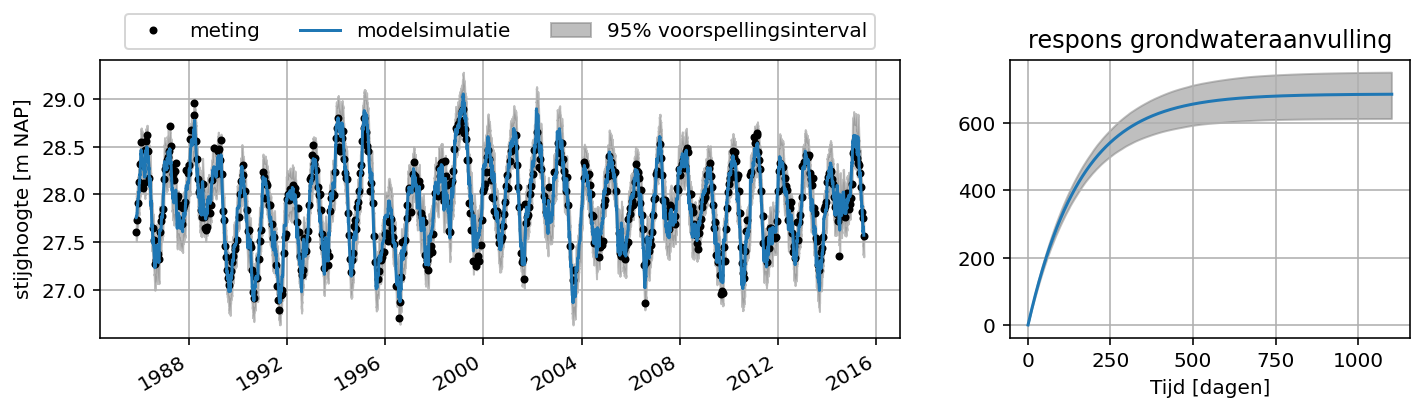

In [17]:
# Plot betrouwbaarheidsinterval
df = ml1.fit.prediction_interval()
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
obs = ml1.oseries.series_original
sim = ml1.simulate()

obs.plot(ax=ax1, linestyle='', marker='.', color='k', label='meting',
         x_compat=True)
sim.plot(ax=ax1, x_compat=True, label='modelsimulatie')
ax1.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% voorspellingsinterval")
ax1.set_ylabel('stijghoogte [m NAP]')
ax1.grid()
ax1.legend(bbox_to_anchor=(0.5, 1.20), ncol=3, loc='upper center')

# plot recharge response
ax2 = fig.add_subplot(gs[0, 1])
df = ml1.fit.ci_step_response("recharge", alpha=0.05, n=1000)
rch_response = ml1.get_step_response("recharge", add_0=True)

rch_response.plot(ax=ax2)
ax2.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% confidence")
ax2.grid()
ax2.set_xlabel("Tijd [dagen]")
ax2.set_title('respons grondwateraanvulling');
plt.tight_layout()

<hr>

### Voorwaarde 1: Autocorrelatie

Autocorrelatie is de correlatie van een tijdreeks met een in de tijd verschoven versie van zichzelf. Als er nog significante autocorrelatie aanwezig is in de ruis, dan wordt het betrouwbaarheidsinterval van de parameter te klein geschat (zie de [Notebook over modelkalibratie](%%) voor een voorbeeld). Deze vorm van correlatie kan worden weergegeven in een autocorrelatiediagram. Daarin is op de horizontale as de verschuiving in de tijd weergegeven (in het Engels: 'lag') en op de verticale as de berekende correlatie. 

De verschuivingen in de tijd (lags) moeten overeenkomen met de tijdstap van het model. Als er op dagbasis gerekend wordt, moet de reeks ook verschoven worden met (veelvouden van) die tijdstap voor het bepalen en beoordelen van de autocorrelatie [(Collenteur, 2018)](#Referenties).

<hr>

#### Voorbeeld autocorrelatiediagram

**Vervangen met voorbeeld met constante tijdstappen.**

De autocorrelatie is voor het voorbeeld model berekend met en zonder een ruismodel. De resultaten zijn weergegeven in onderstaande figuren. De maximale, berekende verschuiving is 365 dagen. Er is niet voor elke verschuiving een correlatie berekend omdat de tijdreeks die we beschouwen metingen om de $\pm$ 14 dagen bevat. 

De blauwe band in de grafiek geeft het 95%-betrouwbaarheidsinterval weer van de berekende autocorrelatie. Als de autocorrelatie van een bepaalde lag binnen het 95% betrouwbaarheidsinterval valt, dan kan met 95% zekerheid gezegd worden dat de autocorrelatie voor die lag nul is. Het is duidelijk te zien dat de residuen van het model zonder ruismodel niet voldoen aan de eis voor de autocorrelatie. Het berekende betrouwbaarheidsinterval voor de parameters zal dus niet goed geschat zijn. In het model met ruismodel zien we dat er geen significante autocorrelatie aanwezig is in de ruis.

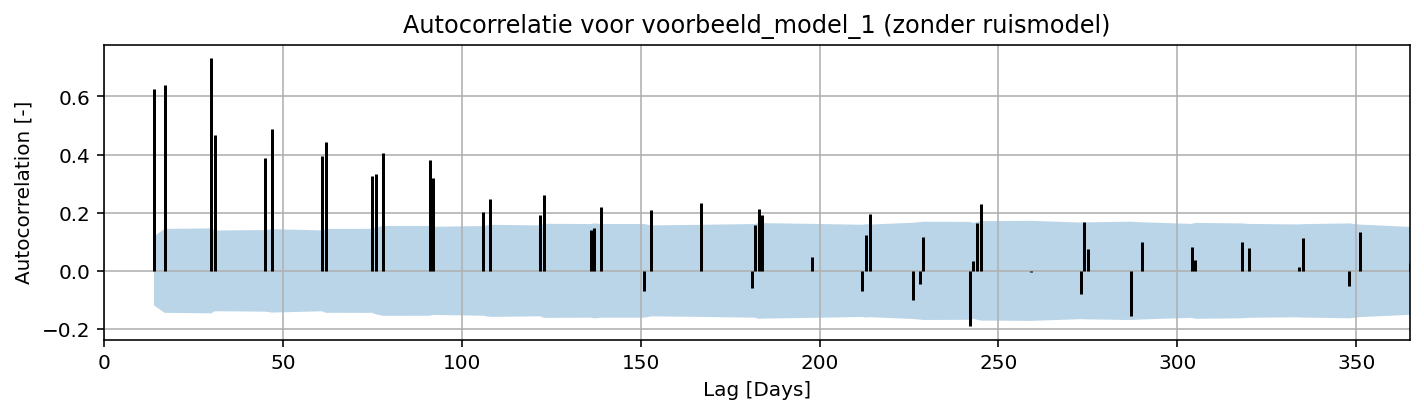

In [18]:
ml1.solve(noise=False, report=False)
ax = ps.stats.plot_acf(ml1.residuals(), figsize=(10, 3), alpha=0.05)
ax.set_title("Autocorrelatie voor voorbeeld_model_1 (zonder ruismodel)")
plt.tight_layout()
ylim = ax.get_ylim()

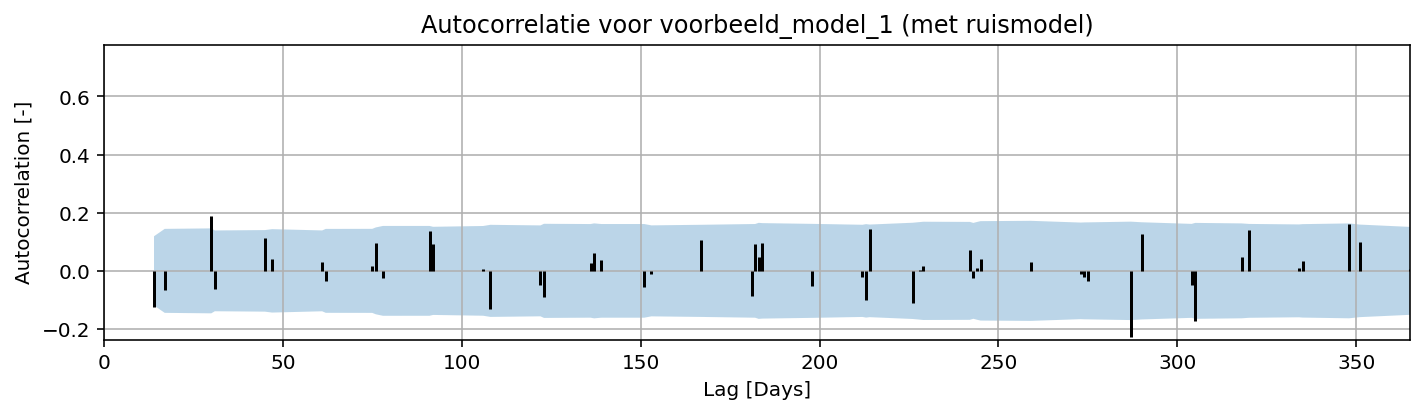

In [19]:
ml1.solve(noise=True, report=False);
ax = ps.stats.plot_acf(ml1.noise(), figsize=(10, 3), alpha=0.05)
ax.set_ylim(ylim)
ax.set_title("Autocorrelatie voor voorbeeld_model_1 (met ruismodel)");
plt.tight_layout()

### Voorwaarde 2: Normale verdeling ruis

Een andere voorwaarde voor witte ruis is dat deze voldoet aan een, bij voorkeur, normale statistische verdeling. De verdeling van de ruis kan weergegeven worden met een histogram in combinatie met een normale kansverdeling. Visueel kan dit beoordeeld worden door een histogram te maken van de residuen/ruis en deze te vergelijken met een normale verdeling met $\mu$ gelijk aan het gemiddelde van de ruis, en $\sigma$ gelijk aan de standaardafwijking van de ruis.

<hr>

#### Voorbeeld visualisatie normale verdeling ruis

Voor het voorbeeld model is een histogram geplot van de ruis en wordt deze vergeleken met de normale verdeling. Dit is in de linker grafiek weergegeven. In de rechter grafiek is dezelfde analyse op een andere manier weergegeven, een zogenaamde "probability plot". Als de blauwe punten op de zwarte rechte lijn liggen is de ruis normaal verdeeld.

Op basis van deze resultaten wordt ingeschat dat de verdeling van de ruis de normale verdeling voldoende goed benaderd om het model op dit aspect goed te keuren. 

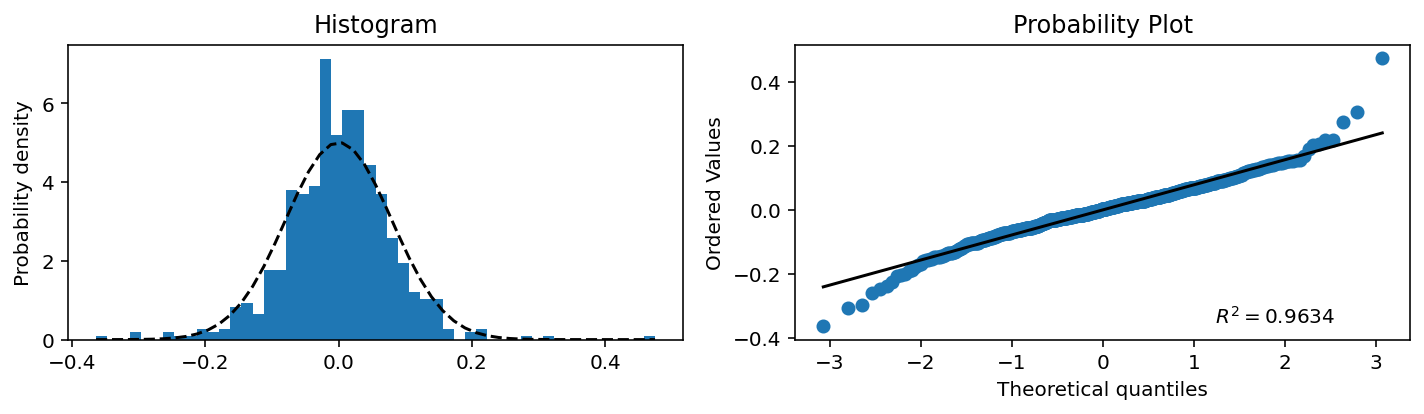

In [20]:
# Plot the histogram for normality and add a 'best fit' line
bins = 50
series = ml1.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, 'k--')
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")

# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color('C0')
ax2.get_lines()[1].set_color("k")
plt.tight_layout()

### Voorwaarde 3: Homoscedasticiteit

De derde statistische voorwaarde voor witte ruis is dat de ruis homoscedastisch moet zijn. Een tijdreeks is homoscedastisch als de variantie onafhankelijk is. Één van de mogelijkheden om hier naar te kijken is via de absolute waarde van de reeks. Als de ruis niet homoscedastisch is (oftewel heteroscedastisch) dan is de variantie van de ruis afhankelijk van de stijghoogte. Dit kan visueel beoordeeld worden door de ruis uit te zetten tegen de stijghoogtemetingen. 

Als de spreiding van de ruis niet gelijk is over het gehele bereik van de stijghoogtemetingen dan is de ruis heteroscedastisch. Dit betekent nog niet zonder meer dat de ruis homoscedastisch is. De variantie van de ruis kan nog op andere manieren gecorelleerd zijn, bijvoorbeeld in de tijd. 

<hr>

#### Voorbeeld visualisatie homoscedasticiteit

Voor voorbeeldmodel 1 is de ruis uitgezet tegen de metingen. De spreiding in de ruis lijkt redelijk constant te zijn over het bereik van de stijghoogtemetingen. Voor de absolute waarde lijkt er dus sprake te zijn van homoscedastische ruis.

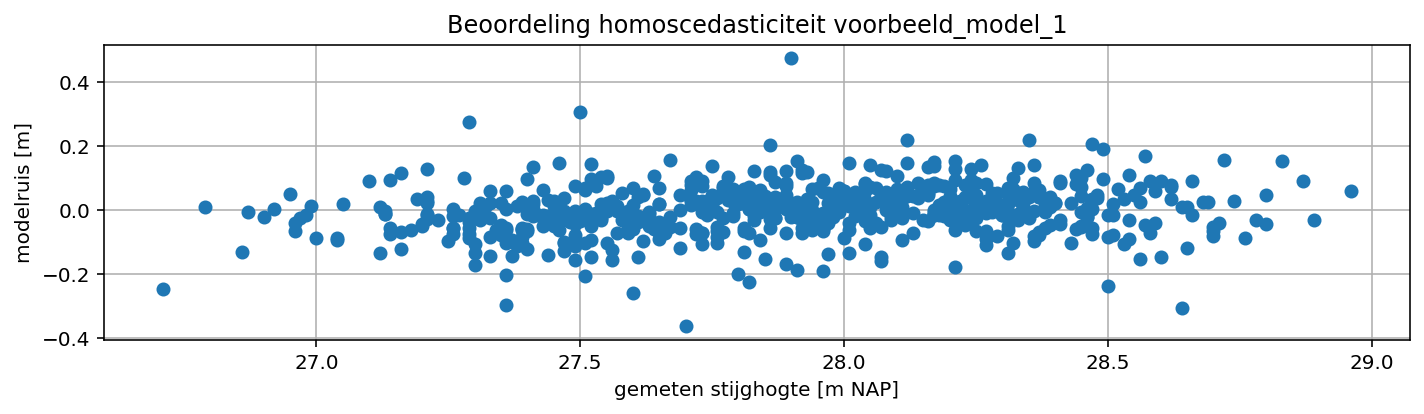

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(ml1.observations(), ml1.noise(), marker="o", linestyle=" ")
ax.set_xlabel("gemeten stijghogte [m NAP]")
ax.set_ylabel("modelruis [m]")
ax.set_title("Beoordeling homoscedasticiteit voorbeeld_model_1")
ax.grid()
plt.tight_layout()

### Voorwaarde 4: Correlatie ruis met verklarende tijdreeks

**De uitleg bij deze voorwaarde is nog een concept.**

De laatste voorwaarde ten aanzien van de ruis is dat deze niet gecorreleerd is met een van de verklarende reeksen in het tijdreeksmodel. Als dit wel het geval is, is de gehanteerde responsfunctie blijkbaar niet in staat om het gedrag van de stijghoogte op basis van de verklarende reeks volledig te beschrijven. In dat geval kan de onzekerheid van de parameters niet nauwkeurig worden bepaald en moet de modelstructuur aangepast worden. 

<hr>

## Hydrologische beoordeling<a id='hydrologisch-beoordeling'></a>

Tijdreeksmodellen worden veel gebruikt om systeem-identificatie uit te voeren, waarbij de bijdrages van verschillende invloeden aan veranderingen in de stijghoogte worden ingeschat. Vanuit vraagstukken uit de praktijk wordt tijdreeksanalyse vaak toegepast op een heel meetnet, of op meerdere peilbuizen binnen een interessegebied. De hydrologische beoordeling van individuele, maar ook hele sets van tijdreeksmodellen is interessant om uit te voeren. 

### Hydrologie<a id='hydrologie'></a>

Het beoordelen van modellen op basis van hydrologische aspecten kan allerlei vormen aannemen. De vragen daarbij zijn eigenlijk "werkt het systeem zoals ik denk dat het werkt" en "is wat ik bereken hydrologisch plausibel?". Daarbij zijn modellen die wel aan de verwachtingen voldoen net zo interessant als de modellen die daar niet aan voldoen. Denk bijvoorbeeld aan een model met grondwateraanvulling en een onttrekkingsdebiet als verklarende variabelen. Een eerste eenvoudige hydrologische beoordeling is de vraag of de stijghoogte ook toeneemt als het regent, en of deze daalt als er grondwater onttrokken wordt. Is dat niet het geval, dan is de kans groot dat het model niet betrouwbaar is.

Op basis van de hydrologie kunnen tijdreeksmodellen beoordeeld worden, maar andersom kunnen de modelresultaten ook het hydrologisch inzicht in het systeem vergroten.

<hr>

#### Voorbeeld hydrologische beoordeling

Als voorbeeld van een hydrologische beoordeling van een tijdreeksmodel wordt de respons van een onttrekking beschouwd. In onderstaande figuur zijn twee verschillende stapresponsen weergegeven met een onzekerheidsbandbreedte. De bandbreedte van 2x de standaardafwijking is in dit geval berekend aan de hand van de onzekerheid in de gain parameter (de parameter die het stationaire effect van de onttrekking bepaald). In de linker grafiek is de onzekerheid van de staprespons klein, met andere woorden, de parameters kunnen relatief nauwkeurig bepaald worden in de optimalisatie. In de rechter grafiek is deze onzekerheid veel groter, de invloed van de onttrekking kan dus niet nauwkeurig worden ingeschat in de optimalisatie. In dit geval betekent een positieve staprespons dat de onttrekking een verlaging van de stijghoogte veroorzaakt.

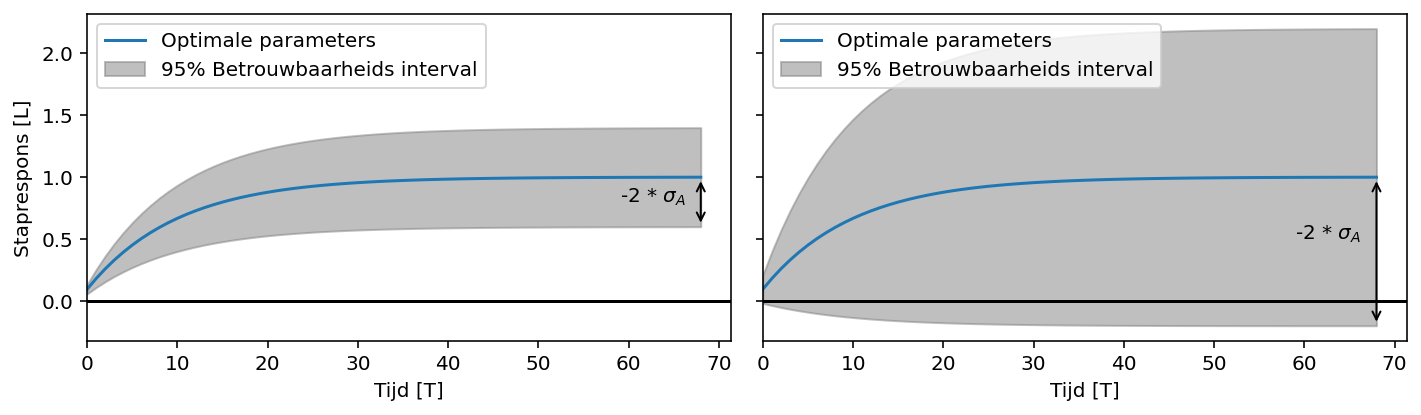

In [22]:
# initaliseer een Gamma responsfunctie
rfunc = ps.Gamma()
p = rfunc.get_init_parameters("")

# bereken staprespons en 95% bandbreedte
b = rfunc.step(p=p.initial.values)
b1 = rfunc.step(p=[1.4, 1, 10])
b2 = rfunc.step(p=[0.6, 1, 10])
t = np.arange(len(b))

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 3))


# Plot Links
ax[0].fill_between(t, b2, b1, color='gray', alpha=0.5,
                   label='95% Betrouwbaarheids interval')
ax[0].plot(b, label="Optimale parameters")
ax[0].axhline(0, c='k')
ax[0].legend(loc=2)
ax[0].set_xlim(0)
ax[0].set_xlabel("Tijd [T]")
ax[0].set_ylabel("Staprespons [L]")
ax[0].annotate('', xy=(t[-1], b[-1]), xycoords='data', xytext=(t[-1], b2[-1]),
               textcoords='data', arrowprops={'arrowstyle': '<->'})
ax[0].annotate('-2 * $\sigma_A$', xy=(t[-10], 0.8), xycoords='data',
               xytext=(0, 0), textcoords='offset points')


# Plot rechts
# bereken staprespons en 95% bandbreedte
b1 = rfunc.step(p=[2.2, 1, 10])
b2 = rfunc.step(p=[-0.2, 1, 10])
ax[1].fill_between(t, b2, b1, color='gray', alpha=0.5,
                   label='95% Betrouwbaarheids interval')
ax[1].plot(b, label="Optimale parameters")
ax[1].axhline(0, c='k')
ax[1].legend(loc=2)
ax[1].set_xlabel("Tijd [T]")
ax[1].set_xlim(0)
ax[1].annotate('', xy=(t[-1], b[-1]), xycoords='data', xytext=(t[-1], b2[-1]),
               textcoords='data', arrowprops={'arrowstyle': '<->'})
ax[1].annotate('-2 * $\sigma_A$', xy=(t[-10], 0.5), xycoords='data',
               xytext=(0, 0), textcoords='offset points')

plt.tight_layout()

*Stationaire invloed van een onttrekking met een kleine onzekerheid (links) en een grote onzekerheid (rechts).*

Vanuit de hydrologie moet de onttrekking voor een daling van de grondwaterstand zorgen, maar in het geval van het onzekere model (rechts) is er een een meer dan 5%-kans dat de onttrekking een verhoging van de grondwaterstand veroorzaakt. De bandbreedte is dusdanig groot dat er een kans is dat de staprespons ook negatief kan zijn. In dat geval kunnen we stellen dat dat hydrologisch gezien niet plausibel is. De onttrekking heeft mogelijk geen significante invloed op de stijghoogte.

<hr>

### Geheugen van de respons

Een responsfunctie zegt onder andere iets over de traagheid waarmee de stijghoogte zich aanpast aan een verandering in een verklarende variabele. Een simpel voorbeeld is bijvoorbeeld hoe lang een verhoging van de stijghoogte aanhoudt na een bui. De tijd tot het effect van een verandering in een verklarende variabele op de stijghoogte verwaarloosbaar klein is wordt vaak het geheugen van de respons genoemd. 

Als het geheugen van de respons langer is dan de lengte van de tijdreeks waarop het tijdreeksmodel gekalibreerd wordt, dan is de tijdreeks eigenlijk niet voldoende lang om een dergelijke trage respons nauwkeurig in te schatten. Dus in dat geval zou het tijdreeksmodel daarop afgekeurd kunnen worden. 

Een andere manier om het geheugen van de respons te beoordelen is vanuit de hydrologie. Vanuit de hydrologische systeemkennis is het wellicht mogelijk om grenzen af te leiden ten aanzien van het geheugen van de respons, of door meerdere modellen te vergelijken kan beoordeeld worden of het geheugen van de respons plausibel is. Dit laatste voorbeeld is een vorm van ruimtelijke beoordeling, dat verder op in dit notebook nog aan bod komt. 


<hr>

#### Voorbeeld bepalen geheugen van de responsfunctie

Het geheugen van de responsfunctie kan niet bepaald worden door te kijken waar de respons gelijk is aan nul. De meeste responsfuncties zijn nooit gelijk aan nul maar benaderen nul als $t \rightarrow \infty$. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de respons is uitgewerkt. Hieronder is dit visueel weergegeven.

Geheugen (t_95) = 351 dagen


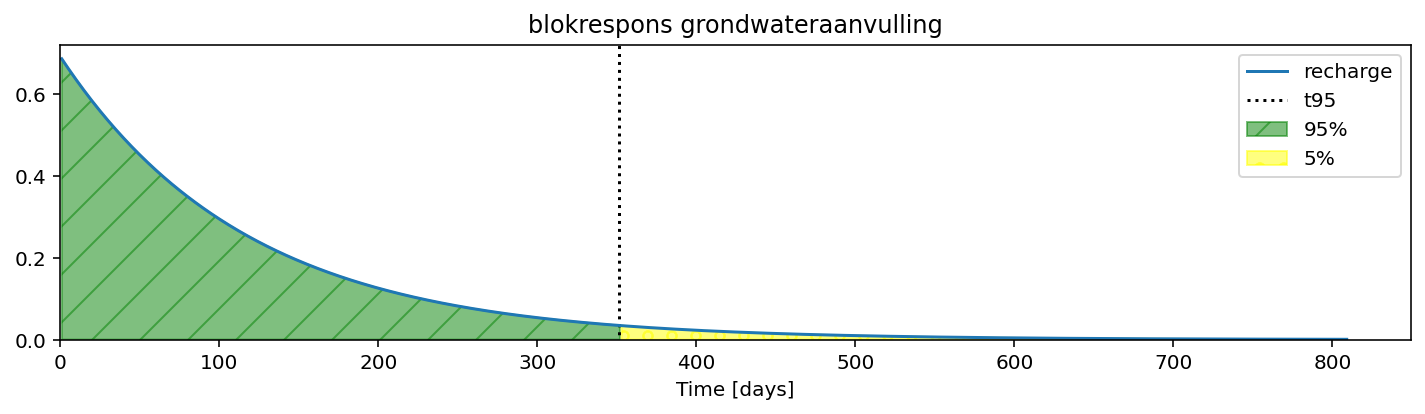

In [30]:
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
t95 = resp_func.get_tmax(ml1.get_parameters('recharge'), cutoff=0.95)
print(f'Geheugen (t_95) = {t95:.0f} dagen')

ax = ml1.plots.block_response(figsize=(10, 3))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=1.5)

block_response = sm.rfunc.block(ml1.get_parameters('recharge'))

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                hatch='/', where=range(len(block_response)) < t95,
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('blokrespons grondwateraanvulling');
plt.tight_layout()

<hr>

#### Voorbeeld geheugen 1

Hieronder zijn van het voorbeeldmodel de blokrespons en de modelresultaten in één figuur geplot. Bij dit model is de lengte van het tijdreeksmodel een aantal maal groter dan het geheugen van de responsfunctie. Daarmee kunnen we  stellen dat de tijdreeks voldoende lang is om de respons te kunnen inschatten.

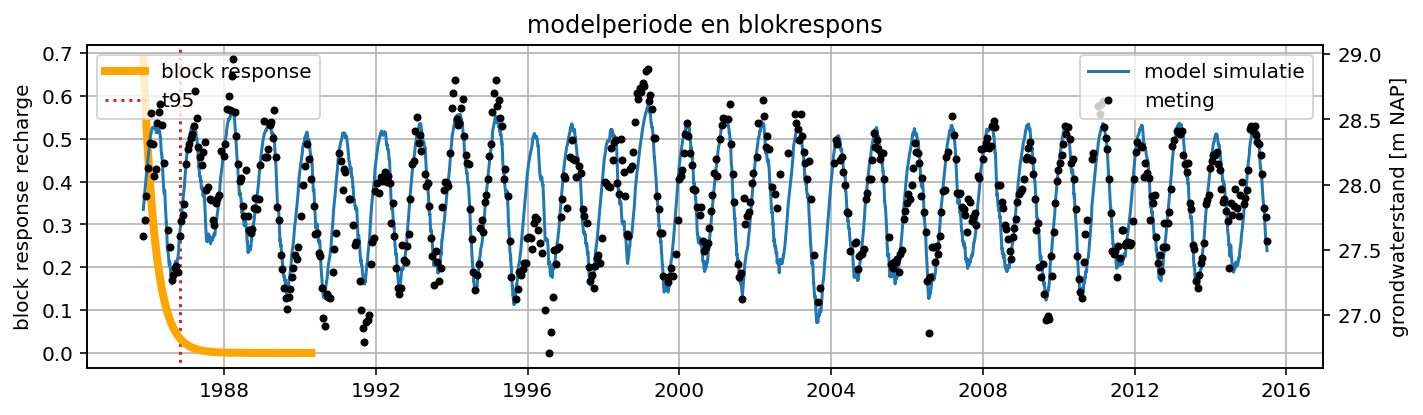

In [31]:
# get response function
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 3))
block_resp = resp_func.block(
    ml1.get_parameters('recharge'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml1.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=4)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)
ax.set_title('modelperiode en blokrespons')

# plot t95 response functie
t95 = ml1.stressmodels['recharge'].rfunc.get_tmax(
    ml1.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml1.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=1.5)
ax.set_ylim(ylim)
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml1.simulate(), label='model simulatie')  # , lw=0.2)
ax2.plot(ml1.oseries.series_original[:],
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(loc=1);
plt.tight_layout()

<hr>

#### Voorbeeld geheugen 2

Voor een ander voorbeeldmodel is ook de blokrespons en de modelresultaten in één figuur geplot. Bij dit model is de lengte van het tijdreeksmodel kleiner dan het geheugen van de responsfunctie. Als de respons langer is dan de meetreeks, kan op basis van de gegevens niet ingeschat worden of de respons terecht zo lang is. In dit geval kan gesteld worden dat de tijdreeks niet voldoende lang is om een tijdreeksmodel voor af te leiden. 

In [32]:
ml_voorbeeld = ps.io.load(os.path.join('data', 'voorbeeld_geheugen.pas'))
ml_voorbeeld.solve(report=False)

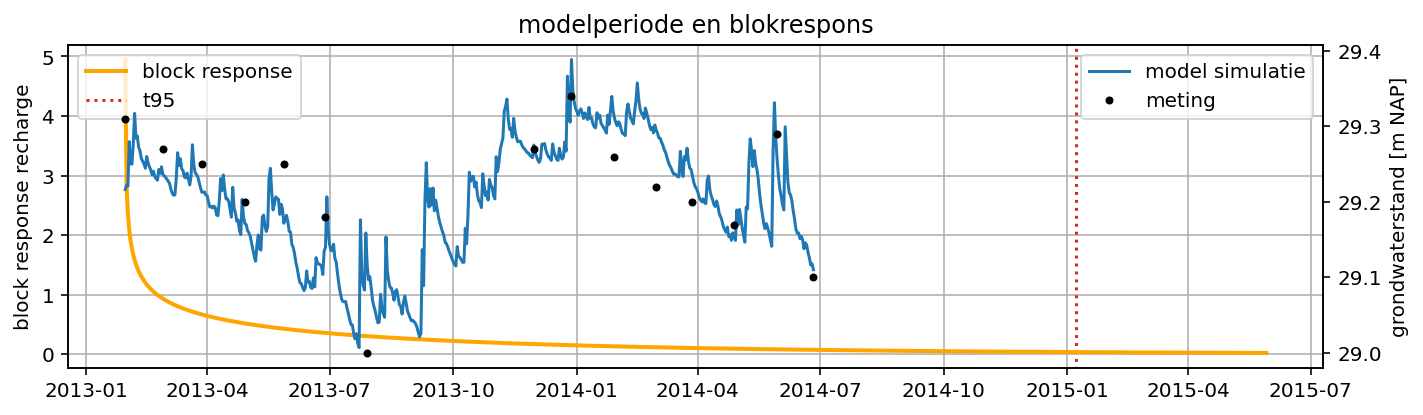

In [33]:
# get response functie
sm = ml_voorbeeld.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 3))
block_resp = resp_func.block(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.97)

# plot response functie
ax.plot(pd.date_range(ml_voorbeeld.settings['tmin'], periods=len(block_resp)), 
        block_resp, label='block response', color='orange', lw=2)
ax.grid()
ax.set_ylabel('block response recharge')
ax.set_title('modelperiode en blokrespons')

# plot t95 response functie
t95 = ml_voorbeeld.stressmodels['recharge'].rfunc.get_tmax(
    ml_voorbeeld.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml_voorbeeld.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=1.5)
ax.set_ylim(ylim)

ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_voorbeeld.simulate(), label='model simulatie')
ax2.plot(ml_voorbeeld.oseries.series_original,
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
ax2.legend(loc=1);
plt.tight_layout()

<hr>

### Neerslagoverschot

De invloed van neerslag en verdamping wordt vaak meegenomen als het neerslagoverschot, berekend met de volgende formule:

$$ \text{R} = \text{P} + f \cdot \text{E}$$

waarin $\text{R}$ het neerslagoverschot is, $\text{P}$ de neerslag en $\text{E}$ de verdamping. Voor de verdamping wordt in Nederland vaak de referentie-gewasverdamping gebruikt. Dit is een waarde voor de potentiële verdamping van een bepaald gewas. Hoeveel er in werkelijkheid verdampt, de actuele verdamping, is meestal niet bekend. In bovenstaande formule wordt de actuele verdamping berekend door de potentiële verdamping te vermenigvuldigen met de verdampingsfactor $f$. De verdampingsfactor wordt in een tijdreeksmodel vaak geoptimaliseerd. 

De geoptimaliseerde waarde van de verdampingsfactor kan vanuit hydrologisch oogpunt worden beoordeeld. Daarbij kan de volgende betekenis worden gegeven aan de geoptimaliseerde waarde:

- $f<-2$, het neerslagoverschot wordt berekend met een actuele verdamping die meer dan twee maal zo groot is als de referentie-gewasverdamping.
- $-2<f<0$, het neerslagoverschot wordt berekend waarbij de verdamping met een bepaalde factor wordt geschaald.
- $f=0$, de neerslag is voldoende om de stijghoogte te verklaren. De verdamping wordt niet meegenomen in het tijdreeksmodel.
- $f>0$, de verdampingsfactor is positief, dit zou betekenen dat de verdamping zorgt voor een stijging in de stijghoogte. Dit is hydrologisch niet te verklaren.

Naast het beoordelen van de geoptimaliseerde waarde is het ook mogelijk om grenswaarden op te geven waarbinnen een bepaalde parameter geoptimaliseerd mag worden. Daarmee kunnen fysische randvoorwaarden worden opgelegd aan het model. Voor de verdampingsfactor worden vaak de volgende grenzen gehanteerd:
- $f<0$, de verdamping moet voor een verlaging van de stijghoogte zorgen. De verdampingsfactor moet dus kleiner zijn dan nul. 
- $f>-2$, de actuele verdamping die wordt gebruikt voor het neerslagoverschot mag niet groter zijn dan twee maal de referentie-gewasverdamping. De referentie-gewasverdamping gaat uit van een gewas dat goed is voorzien van water en nutriënten. Het is dus niet logisch dat de actuele verdamping nog eens twee maal zo groot is.

#### Verdampingsfactor en gewasfactor

In veel grondwatermodellen wordt een gewasfactor gebruikt om de referentiegewasverdamping om te rekenenen naar de actuele verdamping. Deze factor wordt vaak vergeleken met de verdampingsfactor in tijdreeksmodellen. Hoewel er zeker overeenkomsten zijn tussen de factoren zijn er ook een paar belangrijke verschillen:

- De verdampingsfactor wordt in een tijdreeksmodel geoptimaliseerd samen met andere parameters. De verdampingsfactor kan gecorreleerd zijn aan andere modelparameters. Zo kan het gebeuren dat een iets te hoge drainagebasis wordt gecompenseerd met een lagere verdampingsfactor. Hierdoor heeft de geoptimaliseerde waarde van de verdampingsfactor alleen betekenis in combinatie met andere modelparameters en is het daarmee niet direct te vergelijken met een fysische gewasfactor. 
- De werkelijke verdamping (of transpiratie) van een gewas varieert sterk gedurende het jaar afhankelijk van het seizoen en de (groei-)eigenschappen van het gewas. De gewasfactor is dus niet constant. In veel tijdreeksmodellen wordt de verdampingsfactor wel als constante aangenomen. 

<hr>

#### Voorbeeld verdampingsfactor

De tijdreeksen uit het basismodel zijn gebruikt om het effect van de verdampingsfactor op de modelresultaten weer te geven. Eerst is het neerslagoverschot weergegeven met verschillende verdampingsfactoren. Daaronder zijn de modelresultaten weergegeven van steeds hetzelfde model welke telkens geoptimaliseerd is met een andere vaste waarde voor de verdampingsfactor. 

In de grafieken vallen een aantal zaken op:
- bij een verdampingsfactor van $f=0$ wordt verdamping niet meegenomen, het model wordt alleen geoptimaliseerd o.b.v. de neerslag. De fit tussen gemodelleerde en gesimuleerde grondwaterstanden is slecht.
- bij een verdampingsfactor van $f=-1,3$ wordt de beste fit verkregen. Dit is de optimale waarde van  verdampingsfactor uit het oorspronkelijke model.
- bij een verdampingsfactor van $f=-2,0$ weegt de verdamping 2x zwaarder dan de neerslag en is de fit van de modelsimulatie met de metingen behoorlijk goed.
- bij een onrealistische verdampingsfactor van $f=-10,0$ weegt  de verdamping 10 keer zwaarder dan de neerslag. Omdat de actuele verdamping extreem wordt overschat is het effect van de neerslag bijna niet meer terug te zien in de gesimuleerde reeks.

Tot slot is voor alle modellen ook de geoptimaliseerde drainagebasis getoond. Hierin is de correlatie te zien met de verdampingsfactor. Als in de optimalisatie de verdampingsfactor wordt vastgezet op een lage waarde wordt dit gecompenseerd met een hoge drainagebasis.

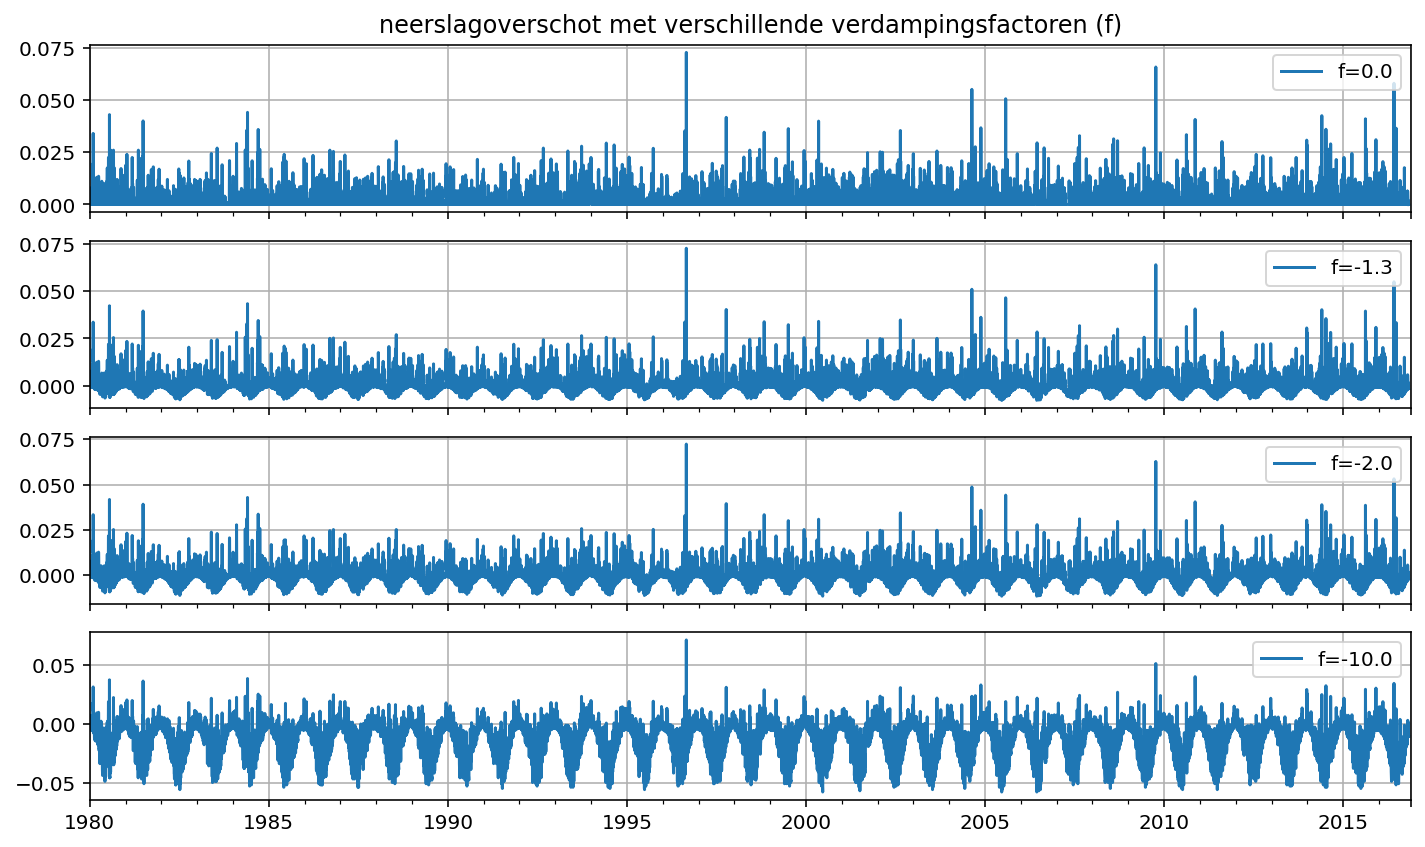

In [27]:
# inladen voorbeeld model
ml1 = ps.io.load("./data/basic_model.pas")

neerslag, verdamping = ml1.stressmodels['recharge'].stress

# berekenen en plotten verdampingsfactoren
verdampingsfactoren = [1e-10, ml1.parameters.loc['recharge_f' ,'optimal'], -2.0, -10.0 ]

fig, ax_list = plt.subplots(figsize=(10, 6), nrows=len(verdampingsfactoren))
for i, f in enumerate(verdampingsfactoren):
    neerslagoverschot = neerslag.series_validated + f * verdamping.series_validated
    neerslagoverschot.plot(ax=ax_list[i], label=f'f={f:.1f}')
    ax_list[i].grid()
    ax_list[i].legend(loc=1)
    if i!= len(verdampingsfactoren)-1:
        ax_list[i].set_xticklabels([])
ax_list[0].set_title('neerslagoverschot met verschillende verdampingsfactoren (f)');
plt.tight_layout()

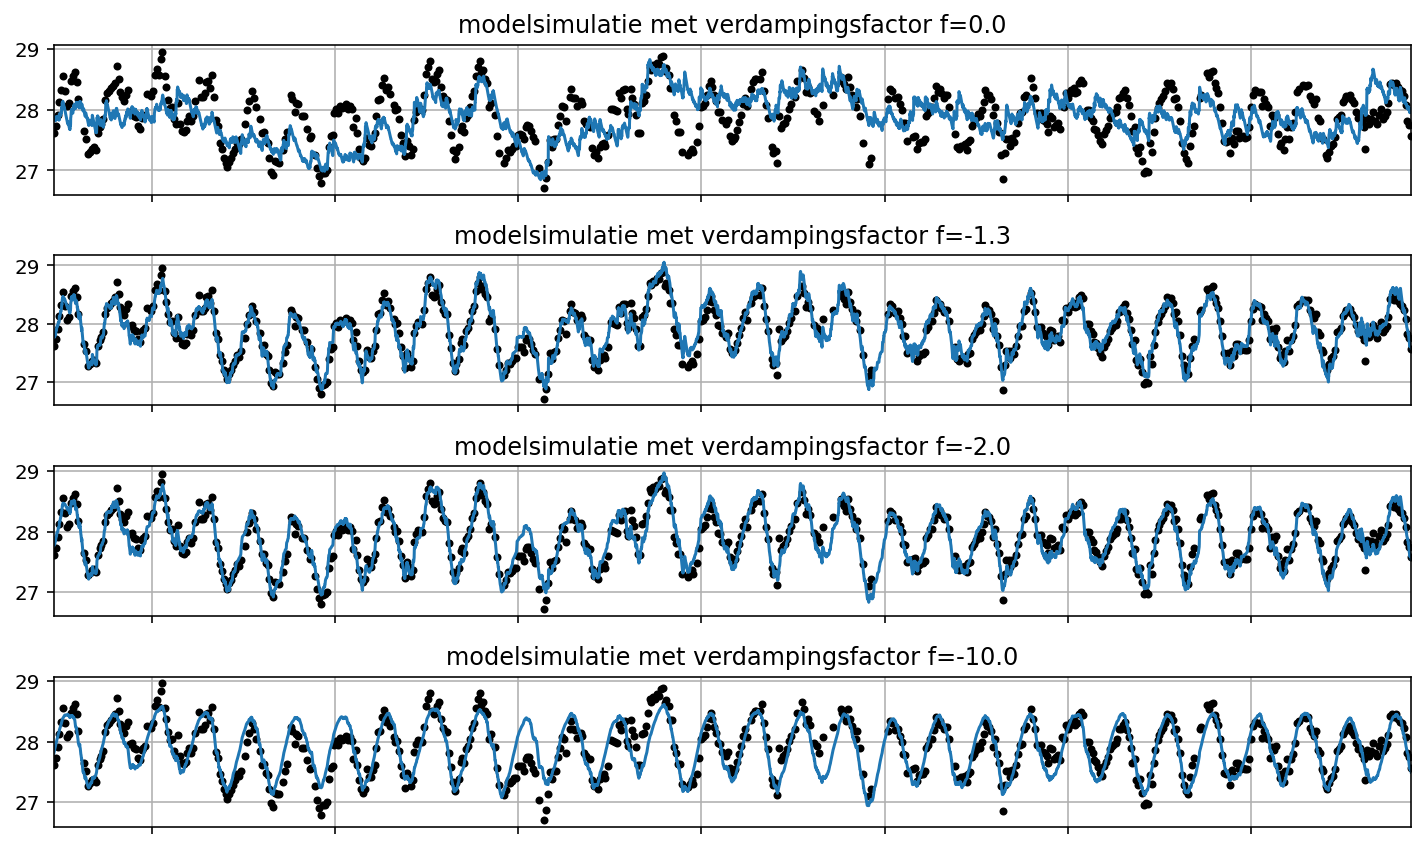

In [28]:
# inladen voorbeeld model
ml1 = ps.io.load("./data/basic_model.pas")
neerslag, verdamping = ml1.stressmodels['recharge'].stress

# berekenen en plotten verdampingsfactoren
verdampingsfactoren = [1e-10, ml1.parameters.loc['recharge_f' ,'optimal'], -2.0, -10.0 ]

fig, ax_list = plt.subplots(figsize=(10, 6), nrows=len(verdampingsfactoren))
results_df = pd.DataFrame(index = verdampingsfactoren, columns=['drainagebasis', 'EVP'])

for i, f in enumerate(verdampingsfactoren):
    ml1.set_parameter('recharge_f', initial=f, vary=False)
    ml1.parameters.loc["recharge_f", "optimal"] = f
    ml1.solve(report=False)
    ml1.plot(ax=ax_list[i], label=f'f={f:.1f}', legend=False)
    ax_list[i].set_ylabel("")
    ax_list[i].grid()
    if i != 4:
        ax_list[i].set_xticklabels([])
    results_df.loc[f, 'drainagebasis'] = f'{ml1.parameters.loc["constant_d", "optimal"]:.2f}'
    results_df.loc[f, 'EVP'] = f'{ml1.stats.evp():.2f}'
    
    ax_list[i].set_title(f'modelsimulatie met verdampingsfactor f={f:.1f}')
    #print(f'modelsimulatie met verdampingsfactor f={f:.1f} heeft een geoptimaliseerde drainagebasis van {ml1.parameters.loc["constant_d", "optimal"]:.2f} m')

results_df.index = [f'{i:.1f}' for i in ([0] + verdampingsfactoren[1:])]
results_df.index.name = 'verdampingsfactor'
ax_list[-1].set_xlim(ax_list[-2].get_xlim())
ax_list[-1].set_ylabel('');
plt.tight_layout()

<hr>

#### Parameter correlatie
Bij de optimalisatie van tijdreeksmodellen kan ook worden gekeken naar de correlaties tussen parameters. Wanneer een model parameters bevat die 100% gecorreleerd zijn dan kan een aanpassing in de ene parameter gecompenseerd worden met een aanpassing aan de gecorreleerde parameter terwijl de fit van het model hetzelfde blijft. Een hoge parameter correlatie is geen probleem voor de betrouwbaarheid van het tijdreeksmodel. In het model wordt immers telkens de combinatie van deze parameters gebruikt om een simulatie uit te voeren. Hoge correlaties zorgen er wel voor dat de absolute waarde van de geöptimaliseerde parameter niet los beschouwd mag worden van de absolute waarde van de gecorreleerde parameter.

<hr>

#### Voorbeeld parameter correlaties

De verdampingsfactor en de drainagebasis zijn parameters die vaak sterk gecorreleerd zijn. In het model uit het vorige voorbeeld is de correlatie tussen de verdampingsfactor en de drainagebasis -0.98. In het vorige voorbeeld zijn de modellen telkens doorgerekend met een andere verdampingsfactor, in de resultaten van dit model kunnen we mooi het effect van de hoge correlatie met de drainagebasis zien. In onderstaande tabel zijn de waardes van de verdampingsfactor, geoptimaliseerde drainagebasis en de EVP weergegeven. Het is duidelijk te zien dat bij een hogere verdampingsfactor de geoptimaliseerde drainagebasis lager ligt. Ook is zichtbaar dat de EVP slechts 1,5 procentpunt lager wordt wanneer een de verdampingsfactor op -2.0 wordt gezet ten opzichte van het optimale model. De waarde van de drainagebasis wordt hoger om te compenseren voor deze toename in verdamping. In dit geval kunnen de absolute waarde van de drainagebasis en verdampingsfactor dus niet los van elkaar worden geïnterpreteerd.

In [34]:
results_df

,drainagebasis,EVP
verdampingsfactor,,
0.0,25.04,15.98
-1.3,27.92,92.91
-2.0,28.48,91.46
-10.0,29.03,75.43


<hr>

### Ruimtelijke beoordeling

In veel studies wordt tijdreeksanalyse toegepast op meerdere stijghoogtemeetpunten. Deze studies hebben bijvoorbeeld als doel om uit te zoeken waar de stijghoogtes goed verklaard kunnen worden aan de hand van een grondwateraanvulling, of willen graag uitzoeken wat de invloed is van een drinkwaterwinning op de stijghoogte, en zo zijn er tal van andere voorbeelden te bedenken. In dit soort studies is het nuttig om een ruimtelijke beoordeling te doen van de resultaten. Voor voorbeelden van ruimtelijke analyses, zie bijvoorbeeld [Baggelaar (1988)](#Referenties), [Asmuth (2012)](#Referenties), en [Berendrecht (2016)](#Referenties). 

Dit aspect wordt aan de hand van het volgende voorbeeld toegelicht.

<hr>

#### Voorbeeld hydrologische ruimtelijke beoordeling

Een voorbeeld van ruimtelijke beoordeling van tijdreeksmodellen wordt gegeven aan de hand van [Collenteur et al. (2019)](#Referenties). In die studie zijn tijdreeksmodellen afgeleid voor peilbuizen binnen een straal van $\pm$ 5 km rondom een drinkwater winning van Brabant Water bij Seppe. In deze tijdreeksmodellen zijn neerslag, verdamping en het onttrekkingsdebiet van winning Seppe als verklarende variabelen meegenomen. Vervolgens zijn de tijdreeksmodellen geoptimaliseerd. In onderstaande figuur zijn de berekende stationaire invloeden (ook wel bekend als de 'gain') van de winning Seppe uitgezet tegen de afstand tussen de peilbuizen en de winlocatie. Daarbij is onderscheid gemaakt tussen peilbuizen in het eerste en tweede watervoerende pakket. De verticale balken geven de onzekerheid aan, en komen overeen met 2 maal de standaardafwijking van de parameter. De stationaire invloed is berekend voor een onttrekkingsdebiet van 1 miljoen m$^3$/jaar. In de figuur is ook de stationaire invloed van de onttrekking als functie van de afstand opgenomen. Deze is berekend met een 2-laags analytisch elementen grondwatermodel [(Bakker et al., 2003)](#Referenties) en dient als extra controle op de geschatte invloed volgens de tijdreeksmodellen.

<img src="data/drawdown_screenshot.png" width=500 />

*Berekende stationaire invloed winning Seppe als functie van de afstand bij een onttrekkingsdebiet van 1 Mm$^3$/jaar (bron: Collenteur et al. (2019))*

Elk tijdreeksmodel is onafhankelijk ten opzichte van de andere modellen; er wordt per model op basis van de gemeten stijghoogtes ingeschat wat de bijdrages van neerslag, verdamping en onttrekking zijn op de verandering in de grondwaterstand. Het berekende patroon van een grotere verlaging nabij de winning past goed op de theoretische invloed van een onttrekking. Ook het verschil tussen het eerste en tweede watervoerende pakket is duidelijk op te maken uit de resultaten van de tijdreeksmodellen. De resultaten komen ook aardig overeen met een berekening met een eenvoudig grondwatermodel.

Deze onafhankelijke modellen lijken goed in staat om de invloed van de drinkwaterwinning op de stijghoogtes in te schatten. Op basis van deze ruimtelijke beoordeling wordt geconcludeerd dat de tijdreeksmodellen toegepast kunnen worden om verdere analyses te doen over de invloed van de winning. Een ruimtelijke hydrologische beschouwing van de resultaten van meerdere tijdreeksmodellen kan waardevol zijn in de beoordeling.

## Referenties

- Baggelaar, P.K. (1988) Tijdreeksanalyse bij verlagingsonderzoek: principe en voorbeeld. H$_2$O (21) nr. 15
- Bakker, M., and O.D.L. Strack (2003). Analytic Elements for Multiaquifer Flow. Journal of Hydrology, 271(1-4), 119-129.
- Berendrecht, W.L., and F.C. Van Geer (2016) A dynamic factor modeling framework for analyzing multiple groundwater head series simultaneously. Journay of Hydrology, Vol. 536, 50-60.
- Collenteur, R.A. (2018) Over autocorrelatie van tijdreeksmodellen met niet-equidistante tijdstappen, Artesia, Schoonhoven, Nederland.
- Collenteur, R.A., M. Bakker, R. Caljé, S.A. Klop, F. Schaars (2019) Pastas: Open Source Software for the Analysis of Groundwater Time Series. Groundwater, Vol. 57, No. 6, 877–885
- van Geer, F. (2012) Tijdreeksanalyse: Introductie en aandachtspunten. Stromingen 18, nummer 2.
- Jackson et al. (2019) Introductory overview: Error metrics for hydrological modelling - A review of common practices and an open source library to facilitate use and adoption. Environmental Modelling & Software 119, 32-48.
- Knotters, M. (2012) Validatie van tijdreeksmodellen voor de grondwaterstand. Stromingen 18, nummer 2.
- Konikow, L.F. and J.D. Bredehoeft (1992) Groundwater models cannot be validated. Advances in Water Resources, Vol. 15, No. 1, 75-83
- Von Asmuth, J.R., K. Maas, and M.F.P. Bierkens (2002) Transfer function-noise modeling in continuous time using predefined impulse response functions, Water Resour. Res., 38(12), 1287.
- Von Asmuth, J.R., K. Maas, M. Knotters, M.F.P. Bierkens, M. Bakker, T.N. Olsthoorn, D.G. Cirkel, I. Leunk, F. Schaars, and D.C. von Asmuth (2012) Software for hydrogeologic time series analysis, interfacing data with physical insight, Environmental Modelling & Software, 38(0), 178-190.